# Shortest path function

In [43]:
%matplotlib inline
import geopandas as gpd
import folium 
import json
import pandas as pd
import numpy as np

from folium.plugins import HeatMap
from folium.plugins import MarkerCluster
import branca.colormap as cm
from sklearn.cluster import DBSCAN

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

import pickle
import networkx as nx
from scipy import spatial

In [2]:
def WGS84toDutchRD(wgs84East, wgs84North):
    # translated from Peter Knoppers's code

    # wgs84East: longtitude
    # wgs84North: latitude

    # Western boundary of the Dutch RD system. */
    WGS84_WEST_LIMIT = 3.2

    # Eastern boundary of the Dutch RD system. */
    WGS84_EAST_LIMIT = 7.3

    # Northern boundary of the Dutch RD system. */
    WGS84_SOUTH_LIMIT = 50.6

    # Southern boundary of the Dutch RD system. */
    WGS84_NORTH_LIMIT = 53.7

    if (wgs84North > WGS84_NORTH_LIMIT) or \
        (wgs84North < WGS84_SOUTH_LIMIT) or \
        (wgs84East < WGS84_WEST_LIMIT) or \
        (wgs84East > WGS84_EAST_LIMIT):
        resultX = -1
        resultY = -1
    else:
        r = [[155000.00, 190094.945,   -0.008, -32.391, 0.0],
            [-0.705, -11832.228,    0.0  ,   0.608, 0.0],
            [0.0  ,   -114.221,    0.0  ,   0.148, 0.0],
            [0.0  ,     -2.340,    0.0  ,   0.0  , 0.0],
            [0.0  ,      0.0  ,    0.0  ,   0.0  , 0.0]]
        s = [[463000.00 ,      0.433, 3638.893,   0.0  ,  0.092],
            [309056.544,     -0.032, -157.984,   0.0  , -0.054],
            [73.077,      0.0  ,   -6.439,   0.0  ,  0.0],
            [59.788,      0.0  ,    0.0  ,   0.0  ,  0.0],
            [0.0  ,      0.0  ,    0.0  ,   0.0  ,  0.0]]
        resultX = 0
        resultY = 0
        powNorth = 1
        dNorth = 0.36 * (wgs84North - 52.15517440)
        dEast = 0.36 * (wgs84East - 5.38720621)

        for p in range(5):
            powEast = 1
            for q in range(5):
                resultX = resultX + r[p][q] * powEast * powNorth
                resultY = resultY + s[p][q] * powEast * powNorth
                powEast = powEast * dEast
            powNorth = powNorth * dNorth
    return resultX, resultY

Load in data

In [3]:
G = pickle.load(open('NetworkX_graph_new.pickle', 'rb'))

Function to calculate the travel time between two points. The points do not need to be on the network. The nearest node on the networkX graph will be determined. The function can be used for normal travel time and peak hour travel time

In [86]:
# travel_time function
def travel_time_func(point1, point2, time='min'):
    """This function uses the information given in network X to return the travel time between two points.
        point1 and point2 should be tuples with the coordinates in longitude, latitude.
        if time = 'peak', the peak travel time is used. In all other cases the minimum travel time is used."""

    # Determine which travel times to use
    if time == 'peak':
        time_string = 'Peak_travel_time_[s]'
    else:
        time_string = 'Min_travel_time_[s]'

    # Change points to Dutch system
    p1_x, p1_y = WGS84toDutchRD(point1[0], point1[1]) # inspector
    p2_x, p2_y = WGS84toDutchRD(point2[0], point2[1]) # incident

    # Create numpy matrix from nodes
    A = np.array(list(G.nodes()))

    # Get node closest to each point
    dist_node1, index_node1 = spatial.KDTree(A).query([p1_x, p1_y])
    node1 = (A[index_node1][0], A[index_node1][1])

    dist_node2, index_node2 = spatial.KDTree(A).query([p2_x, p2_y])
    node2 = (A[index_node2][0], A[index_node2][1])

    # Get shortest path between nodes
    route = nx.shortest_path(G, node1, node2, time_string)
    travel_time = nx.shortest_path_length(G, node1, node2, time_string)

    return route, travel_time

Now, the incidents data is imported so random points from that data can be used to test the algorithm

In [5]:
incidents = pd.read_csv('Dashboard_data\incidents_data', sep=';')

In [12]:
p1 = (incidents.iloc[0].longitude, incidents.iloc[0].latitude)
p2 = (incidents.iloc[6391].longitude, incidents.iloc[6391].latitude)

In [13]:
short_path, time = travel_time_func(p1, p2)

Plot a simple figure between the two points

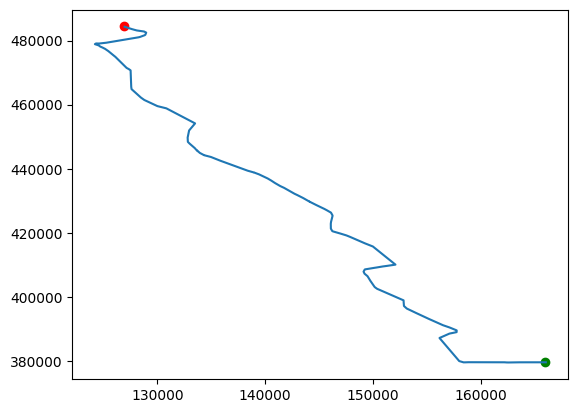

In [14]:
plt.figure()
short_path, time = travel_time_func(p1, p2)
B = np.array(short_path)

plt.plot(B[:, 0], B[:, 1])
plt.scatter(WGS84toDutchRD(p1[0], p1[1])[0], WGS84toDutchRD(p1[0], p1[1])[1], color='r')
plt.scatter(WGS84toDutchRD(p2[0], p2[1])[0], WGS84toDutchRD(p2[0], p2[1])[1], color='g')

Now, a function will be written to show the path on the map. It is still quite slow. If it has to be used more in the future, it needs to be rewritten without a for-loop

In [20]:
edges_arr = np.array(list(G.edges()))

In [82]:
def plot_shortest_path(p1, p2, time_str='minimum'):
    """This function plots the shortest path between two paths.

        point1 and point2 should be tuples with the coordinates in longitude, latitude
        if time = 'peak', the peak travel time is used. In all other cases the minimum travel time is used."""
    
    plt.figure(figsize=(8, 9))
    
    for i in range(len(edges_arr)):
        plt.plot(edges_arr[i,:,0], edges_arr[i,:,1], color='cornflowerblue')


    short_path, times = travel_time_func(p1, p2, time=time_str)
    B = np.array(short_path)

    tt = f'{times//60:.0f} minutes and {times%60:.0f} seconds'

    plt.plot(B[:, 0], B[:, 1], color='red', label=f'Shortest path: {tt}')
    plt.scatter(WGS84toDutchRD(p1[0], p1[1])[0], WGS84toDutchRD(p1[0], p1[1])[1], color='green', label='start point')
    plt.scatter(WGS84toDutchRD(p2[0], p2[1])[0], WGS84toDutchRD(p2[0], p2[1])[1], color='maroon', label='End point')

    plt.title(f'Shortest path for {time_str} travel time')

    plt.legend()

Plot two shortest paths during peak hour time and with the minimum travel time, to see the differences

In [94]:
p1 = (incidents.iloc[0].longitude, incidents.iloc[0].latitude)
p2 = (incidents.iloc[52543].longitude, incidents.iloc[52543].latitude)

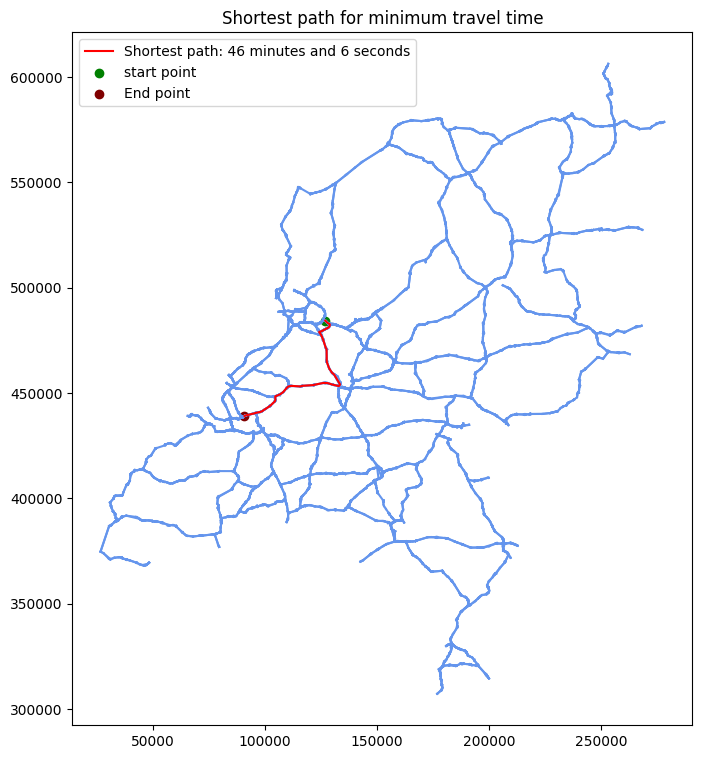

In [95]:
plot_shortest_path(p1, p2)

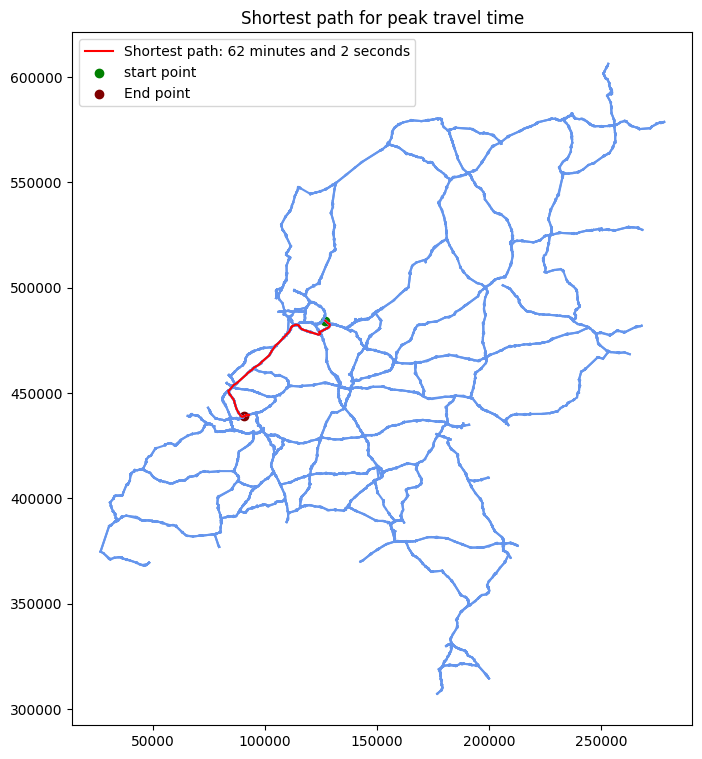

In [96]:
plot_shortest_path(p1, p2, time_str='peak')